In [1]:
from reports_header import *
%matplotlib inline
from IPython.display import set_matplotlib_formats
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"

export_bokeh = False

import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)


In [2]:
## Loading Data

store = pd.HDFStore('../../data/processed/orbf_benin.h5')
data_orbf = store['data']
tarifs = store['tarifs']
store.close()

monitoring_data = open( "../../data/processed/facilities_supervision_trails.pkl", "rb" )
monitored_facilities = pickle.load(monitoring_data)
monitoring_data.close()

pkl_file = open( '../../data/processed/TEMP_aedes_pltdata.pkl', 'rb')
aedes_data = pickle.load(pkl_file)
pkl_file.close()


pkl_file = open( '../../data/processed/TEMP_full_data.pkl', 'rb')
full_data = pickle.load(pkl_file)
pkl_file.close()

## Temporary function until algorithm 1 is thrown into generic functions
def get_validation_set(monitored_facilities):
    out = []
    for i in range(len(monitored_facilities)):
        for date in list(monitored_facilities[i].reports.keys()):
            data = {'fac_id':monitored_facilities[i].facility_id , 
                    'facility_name':monitored_facilities[i].facility_name , 
                   'report_date':date , 
                   'claimed_payment':monitored_facilities[i].reports[date].report_payment['claimed_payment'] , 
                   'verified_payment':monitored_facilities[i].reports[date].report_payment['verified_payment']
                   }
            out.append(data)
    return pd.DataFrame(out)

report_payment_data = get_validation_set(monitored_facilities)

## Just keeping full facilities
facs = list(full_data.index.levels[2])
idx = pd.IndexSlice
report_payment_data = report_payment_data[report_payment_data.facility_name.isin(facs)]

report_payment_data['difference_amount'] = report_payment_data['claimed_payment'] - report_payment_data['verified_payment']

## Introduction

### Some terminology

To differentiate the different types of data that are being handled in the analysis, we will use the following taxonomy :

1. __Claimed data__ is the data sent by the facilities, before any level of verification happens.
2. __Verified data__ is the data verified by OpenRBF teams during supervisions
3. __Validated data__ is the data on which the payment is finally based. This can be the original claimed data, if no verification was made, or it could be the verified data, if a verification was made.

### Objectives

#### Program Monitoring

A first objective of the project is to improve the monitoring of the data collected in the RBF program. This monitoring is aimed at spotting abnormal situations that may appear in the data, and raising alarms to allow program managers to answer to these alarms. We define two main types of issues we want our project to spot :

##### Data quality

The primary goal of RBF is to ensure the proper financing of health services. As such, data quality is an essential element of RBF. Building the trust that the data communicated by facilities reflects the demonstrable results of these facilities is essential to involving funders and other stakeholders in an RBF project.

There are two detrimental situations of bad data quality : 
* __Over reporting__ when the claimed reports are excessively important and do in no way reflect the activity in the facility. In these situations, partners are overpaying for the result in health services. This situation can lead to unsustainable programs, and to breach of trust in RBF.
* __Under reporting__ when claimed payments are way below the actual costs of the facility. In this situation, facilities will come to detrimental situations where they will be underfunded, which could affect their ability to provide proper services in the following months, which would directly affect the health of target populations.

##### Service conformity

In the meantime as RBF data is used to determine payments for facilities, this data can also allow supervising entities to track performances of facilities, and to spot domains in which additional resources or coaching could be useful in order to improve these performances. Defining and measuring what constitutes satisfying service provision from facilites can prove tricky in a program that adresses primary health care services, as it is not easy to determine local needs for such services, as well as local coverage expectations.


#### Program Cost Reduction

A second objective of this project is to help to the reduction of operating costs for the RBF project. These operating costs indeed incude two types of garbage costs that we would like to reduce :

1. Overpayments made to facilities that had overreported on their payments. 
2. Costs of unnecessary supervisions, or of supervisions that had little benefits.

There is a trade-off here between these two costs. Indeed, the goal of supervising facilities is to reduce the amount of payments made that do not correspond to actual services that have been provided. In the meantime on-site verifications are costly, and necessitate the mobilisation of human, logistical and financial resources. There is thus a balance to find between bearing high supervision costs and paying large amounts of undue payments to facilities. 

Our work will be to provide a framework allowing program managers to design data verification schemes that will enact their local decision on this trade off.

## Data Description

### Out of control situations

Based on the available data, we define out problematic data situations based on the payment variations that was implied by the claimed data and the validated data. This definition is based on two separate thresholds :
1. The difference between the expected payment for the facility and the claimed payment should not exceed the supervision cost
2. The claimed payment should not be less than half the expected payment

The mean monthly supervision cost based on data from Aedes appears to be 170 000 CFA Francs.

We flag reports as being over or under reported. The distribution of these different situations is as follows :
* 9% of the reports were claiming excessive amounts that were over the cost of verification
* 0.45% of the reports were claiming amounts that would have resulted in an undefunding of the facilities activities. 
* 53% of the facilities reported at least one _out of control_ overestimation at least once, and 
* 8.42% did an _out of control_ underestimation at least once in the data

In [3]:
mean_supervision_cost = 170000
underfunding_max_risk = 0.5

In [4]:
report_payment_data['ratio'] = report_payment_data['claimed_payment'] / report_payment_data['verified_payment']
report_payment_data['over_declaration'] = report_payment_data['difference_amount'] > mean_supervision_cost
report_payment_data['under_declaration'] = report_payment_data['ratio'] < underfunding_max_risk
report_payment_data['date'] = pd.to_datetime(report_payment_data['report_date'])

out_sup = sum(report_payment_data.over_declaration) / len(report_payment_data)
out_inf = sum(report_payment_data.under_declaration)  / len(report_payment_data)
print('Over declarared reports :' + str(np.round(out_sup * 100 , 2)) + '%')
print('Under declared reports :' + str(np.round(out_inf * 100 , 2)) + '%')

n_facilities = report_payment_data.fac_id.nunique()
n_over_fac = report_payment_data[report_payment_data.over_declaration].fac_id.nunique() / n_facilities
n_under_fac = report_payment_data[report_payment_data.under_declaration].fac_id.nunique() / n_facilities
print('Overdeclaring Facilities :' + str(np.round(n_over_fac * 100 , 2)) + '%')
print('Undedeclaring Facilities :' + str(np.round(n_under_fac * 100 , 2)) + '%')

Over declarared reports :8.99%
Under declared reports :0.45%
Overdeclaring Facilities :52.72%
Undedeclaring Facilities :8.42%


The next graph shows the distribution of the data we want to spot. Red data dots are outside of the zone in which we want the data to be. Reports under the black line were overreporting, and reports over the red line were underreporting too strongly before data validation.

We see that most of the data is in control but there are large tails on the right and slightly on the left of the distributions. 

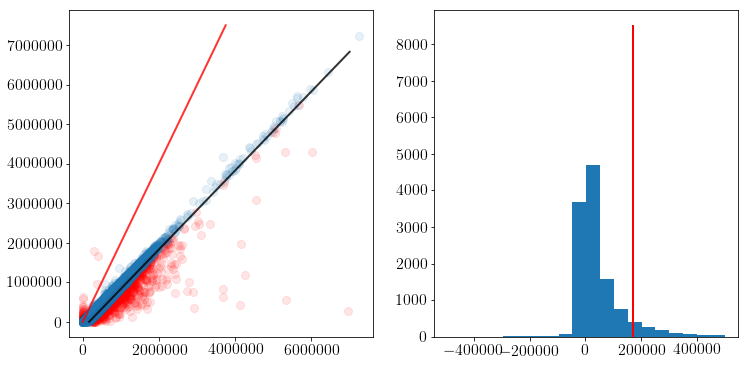

In [5]:
plotting_data = report_payment_data[(report_payment_data['claimed_payment'] < 10000000)]
report_payment_data['alarm'] = report_payment_data['over_declaration'] | report_payment_data['under_declaration']

outliers = plotting_data[plotting_data['over_declaration'] | plotting_data['under_declaration']]
in_control = plotting_data[~ (plotting_data['over_declaration']) & ~(plotting_data['under_declaration'])]

plt.figure(1)
plt.subplot(1,2,1)
plt.plot( outliers.claimed_payment , outliers.verified_payment , 'ro', alpha = 0.1)
plt.plot( in_control.claimed_payment , in_control.verified_payment , 'o' , alpha = 0.1)
plt.plot((0,3750000) , (0,7500000) , 'r-' , alpha = 0.8)
plt.plot((mean_supervision_cost,7000000) , (0,(7000000 - mean_supervision_cost)) , 'k-' , alpha = 0.8)
plotting_data = plotting_data[np.abs(plotting_data['difference_amount']) < 500000]
plt.subplot(1,2,2)
plt.hist(plotting_data[:]['difference_amount'] , bins = 20 )
plt.plot((mean_supervision_cost, mean_supervision_cost), (0, 8500), 'r-')

### Current program Characteristics

In the current supervision regime, costs of verification represent 29 % of the overall program. This is an important cost, especially considering that 92% of the verifications are more costly than the reduction in payment they result in. The process of data verification is thus costly and time consuming for public health authorities. The aim of this project is ot orient these efforts of supervision to maximize the chance of identifying data issues or services problems.

The next graph shows the evolution of the different aggregate categories of cost for the program since its beginning. In (a), we see the evolution of the total monthly cost of the program. The costs have been regular 2014 with a first scale up, and an important scale up mid-2015. The composition of this costs is displayed in the plot (b). We can see that the cumulated difference between claimed and verified payment grow after each scale up, showing a time of adaptation for for health workers who need to learn how to feel reports. We also see how verification costs, with the current full verification format of the program, are steady in time.

Plot (c) shows the share of supervision costs in the total cost of the program. We see that as the program has grown, the share of supervision costs goes down, but stays between a fifth and a third of the total costs of the program. Plot (d) confirms the spikes in overdeclaring facilities after scale-ups, and show that on a regular basis, between 5% and 10% of the facilities are _out of control_, which means a supervision will indeed have a positive impact on the total cost.

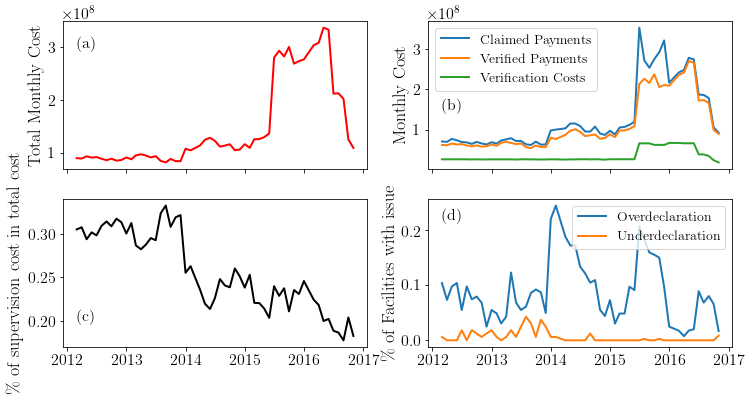

In [6]:
total_claimed_payments =  report_payment_data.groupby(['report_date']).claimed_payment.sum()
total_payments = report_payment_data.groupby(['report_date']).verified_payment.sum()
verification_costs = report_payment_data.groupby(['report_date']).verified_payment.apply(len) * mean_supervision_cost
total_cost = total_payments + verification_costs
perc_verification = verification_costs / total_cost
perc_alarms = report_payment_data.groupby(['report_date']).alarm.sum() / report_payment_data.groupby(['report_date']).alarm.apply(len)

N_overdecl = report_payment_data.groupby(['report_date']).over_declaration.sum()
N_underdecl = report_payment_data.groupby(['report_date']).under_declaration.sum()

perc_overdecl = N_overdecl / report_payment_data.groupby(['report_date']).alarm.apply(len)
perc_underdecl = N_underdecl / report_payment_data.groupby(['report_date']).alarm.apply(len)

f, axarr = plt.subplots(2,2, sharex=True)
axarr[0,0].plot(pd.to_datetime(total_cost[total_claimed_payments < 1e9].index) , total_cost[total_claimed_payments < 1e9].tolist() , color='red')
axarr[0,0].set_ylabel('Total Monthly Cost')
axarr[0,0].text(mdates.date2num(pd.to_datetime(total_cost[total_claimed_payments < 1e9].index[0])) , 3e8 , '(a)')

axarr[0,1].plot(pd.to_datetime(total_claimed_payments[total_claimed_payments < 1e9].index) , total_claimed_payments[total_claimed_payments < 1e9].tolist() , label = 'Claimed Payments')
axarr[0,1].plot(pd.to_datetime(total_payments[total_claimed_payments < 1e9].index) , total_payments[total_claimed_payments < 1e9].tolist() , label = 'Verified Payments')
axarr[0,1].plot(pd.to_datetime(verification_costs[total_claimed_payments < 1e9].index) , verification_costs[total_claimed_payments < 1e9].tolist() , label = 'Verification Costs')
axarr[0,1].set_ylabel('Monthly Cost')
axarr[0,1].legend()
axarr[0,1].text(mdates.date2num(pd.to_datetime(total_cost[total_claimed_payments < 1e9].index[0])) , 1.5e8 , '(b)')

axarr[1,0].plot(pd.to_datetime(perc_verification[total_claimed_payments < 1e9].index) , perc_verification[total_claimed_payments < 1e9].tolist() , color = 'black')
axarr[1,0].set_ylabel('\% of supervision cost in total cost')
axarr[1,0].text(mdates.date2num(pd.to_datetime(total_cost[total_claimed_payments < 1e9].index[0])) , 0.2 , '(c)')


axarr[1,1].plot(pd.to_datetime(perc_overdecl[total_claimed_payments < 1e9].index) , perc_overdecl[total_claimed_payments < 1e9].tolist() , label = 'Overdeclaration')
axarr[1,1].plot(pd.to_datetime(perc_underdecl[total_claimed_payments < 1e9].index)  , perc_underdecl[total_claimed_payments < 1e9].tolist() , label = 'Underdeclaration')
axarr[1,1].set_ylabel('\% of Facilities with issue')
axarr[1,1].legend()
axarr[1,1].text(mdates.date2num(pd.to_datetime(total_cost[total_claimed_payments < 1e9].index[0])) , 0.22 , '(d)')

In order to both reduce the aggregate cost and spot _ooc_ situations, we will define monitoring algorithms and present how these algorithms can be tested and validated before being tested in the field. 

## Methods

### What's in a monitoring algorithm

We define a supervision algorithm in three steps that can be thought of separately :
1. __Data processing :__ In a first stage, the historical input data is processed and acceptable features of the data are infered. The statistics produced at this stage may vary depending on the type of data that is used as input.
2. __Trigger definition :__ A second aspect is the definition of the situation in which the observed data should raise an alarm, and the decision rule that is applied
3. __Implementation strategy :__ Finally, the way the program will implement this algorithm in the field is important. It may be the case that the program will chose to supervise facilities 

### Monitoring strategies

We will compare different monitoring strategies. Strategies will vary on the type of data they will use as input, and the type of data processing that will be applied.

The features will need to be built on different dimensions :
1. Weighted random supervision of facilities
2. Internal consistency of each serie : surveillance
3. Facility consistency with other facilities : hierarchical
4. Profile consistency for the facility / Profile consistency with other facilities

#### Weighted random sampling

A first simple strategy is to randomly draw facilities that will be supervised. The draw can be based on equal weights or on a weighting that will be based on past information on the financial risks of each facility. At this stage of the work, we use a weight determination algorithm designed by Mathieu Antony, from Aedes, and described elsewhere.

#### Longitudinal data / Surveillance approach

In this first approach, we will want to monitor the amounts paid to a facility on a monthly basis, and spot a divergence from the expected _in control_ distribution. To do this, for each facility we will :
1. Model each report serie using Time Series model based on past validated data
2. Get a prediction for the new data
3. Compared the new data to the distribution of the expected data 

This approach is akin to approaches used in syndromic surveillance systems, where targets are raised when some transformation of an error of the number of expected cases reaches a certain threshold.

#### Transversal data / Hierarchical modelling

A second approach is to model how the values reported by each facility differs from the values reported by other facilities. A simple implementation of this approach is to use hierarchical models with fixed effects at facility level, and to analyze the distribution of these fixed effects to spot outliers. 

#### Mixed data / Profile monitoring

Finally, we want to check internal consistency of each reports. Profile monitoring is a way of monitoring the production profile of different health facilities, and to see how they may change with time.

### Algorithm validation methods

In order to test and evaluate the performance of a monitoring algorithm, we simulate the _validation trail_ of this algorithm for each facility. This simulation is done for each facility. At each time step, we process the validated data and define temporary thresholds. We then compare the claimed data for this time step, to the defined thresholds. We then apply the relevant supervision rule for the result of the algorithm. Finally, if the facility is supervised, the verified data is saved as validated data. If the facility is not supervised, we save the claim data as validated data.

## Verification algorithms

### Algorithm 1 : Stratified random supervision

In [7]:
aedes_data = aedes_data[aedes_data.total_payment < 1e9]

### Algorithm 2 : Unexpected overcost supervision

This second algorithm is a longitudinal supervision algorithm approach.

For each time step, for each facility :
1. We fit an ARIMA model to the validated data
2. We forecast the next payment based on this model
3. We compare the forecasted payment to the claimed payment :
    a. If the claimed payment exceeds the expected payment by more than the supervision cost, a supervision is triggered
    b. Else, no supervision is triggered
    
The validation trail for one facility is presented below

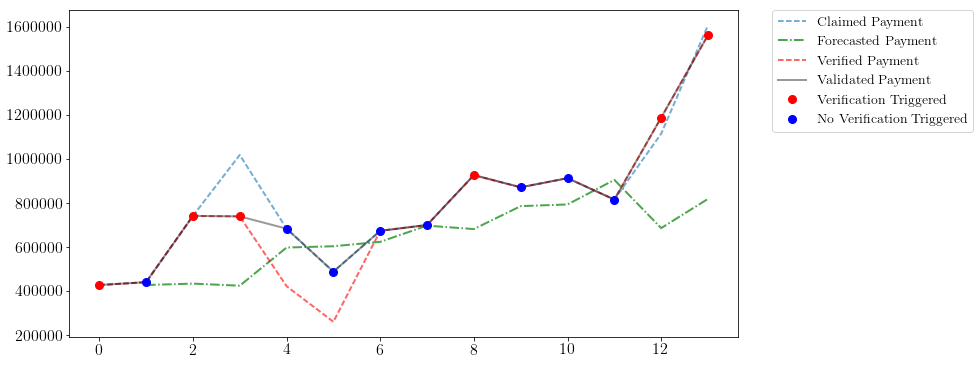

In [9]:
monitored_facilities[200].plot_supervision_trail(tarifs) ;

In [10]:
report_payment_data = report_payment_data.set_index(['fac_id' , 'report_date' ])

In [11]:
def get_report_validation(monitored_facility):
    out_def = ''
    reports_dates = list(monitored_facility.reports.keys())
    for date in reports_dates :
        data = {'sup_alarm':monitored_facility.reports[date].alarm , 'report_date':date , 
                'fac_id':monitored_facility.facility_id }
        if date == reports_dates[0] :
            out = [data]
        if (date == reports_dates[0]) == False : 
                out.append(data)
    out = pd.DataFrame(out)
    
    ## Payment
    indicators = list(monitored_facility.training_set.keys())
    payments = monitored_facility.training_set[indicators[0]] * tarifs[indicators[0]]
    for indic in indicators[1:]:
        payments = payments.add(monitored_facility.training_set[indic] * tarifs[indic] , fill_value=0)
    payment = pd.DataFrame(payments)
    payment = payment.reset_index()
    payment.columns = ['report_date' , 'validated_payment']
    payment['report_date'] = payment.report_date.astype(str).str[0:7]
    out = out.merge(payment , on = 'report_date' , how='outer')
    return out

def sensitivity(test_value):
    return sum((test_value['alarm'] == test_value['sup_alarm']) * test_value['alarm']) / sum(test_value['alarm'])

def npv(test_value):
    return sum((test_value['alarm'] == test_value['sup_alarm']) * ~test_value['alarm']) / sum(test_value['sup_alarm'] == False) 

def ppv(test_value):
    return sum((test_value['alarm'] == test_value['sup_alarm']) * test_value['alarm']) / sum(test_value['sup_alarm'] == True) 


out_df = get_report_validation(monitored_facilities[0])
for i in range(1 , len(monitored_facilities)):
    facility = monitored_facilities[i]
    if facility.facility_name in facs :
        out = get_report_validation(monitored_facilities[i])
        out_df = out_df.append(out)
out_df = out_df.set_index(['fac_id' , 'report_date'])
out_df['alarm'] = report_payment_data['alarm']

print('Strategy Sensitivity : ' + str(sensitivity(out_df)))
print('Strategy Negative Predictive Value : ' + str(npv(out_df)))
print('Strategy Positive Predictive Value : ' + str(ppv(out_df)))


sup_sens = out_df.groupby(level = 1).apply(sensitivity)
sup_npv = out_df.groupby(level = 1).apply(npv)
sup_ppv = out_df.groupby(level = 1).apply(ppv)

Strategy Sensitivity : 0.582897033159
Strategy Negative Predictive Value : 0.9500678993
Strategy Positive Predictive Value : 0.261345852895


The Sensitivity of this strategy is somehow underwhelming, 58% of _ooc situations_ have been identified by our approach. Meanwhile, 5% of the algorithmically validated reports turn out to be in fact problematic. Looking at the plotted data, we can see how the expected payments forecasting method is slow to adapt to new situations, and can be sticky in time. This is however to be expected due to the coarse nature of the forecasting approach, and this weakness of this approach could be mitigated by spending some time tweaking this approach

Meanwhile, we see that the monthly cost of the program with algorithmic verification is slightly less than the cost of full verification. This is due to the huge diminution in verification costs, as the total cost of supervision diminishes to little more than 5% of the total cost of the program.

In the meantime, we see that with this strategy, 466 830 794 CFA Francs would been payed unduly to facilities, over 4 years. This, meanwhile, represents only 5% of the total payments made, and 4.4% of the total cost of the program on the period. We see that a big chunck of these costs happen around the introduction of new facilities, when the algorithms take some time to stabilize.

### Comparisons

In order to compare algorithms, we will compare some characteristics of their validation trail. The figure below presents some characteristics of this trail. Plot (a) shows that the full verification is always more costly than the algorithmic data monitoring strategies. The Algorithms 1a and 1b appear to be very similar in terms of aggregate cost and offer the best cost reduction while Algorithm 2 has a slightly higher total cost. Looking at (b), (c) and (d), we see that the difference in the results of the different algorithms comes from their different positions in the trade-off between supervision cost and overpayment. (b) and (c) show that the reactive algorithm triggers a much lower number of supervisions than the random sampling algorithms. As a result, plot (d) shows that Algorithm 2 results in higher levels of overpayment than algorithms 1a and 1b. 

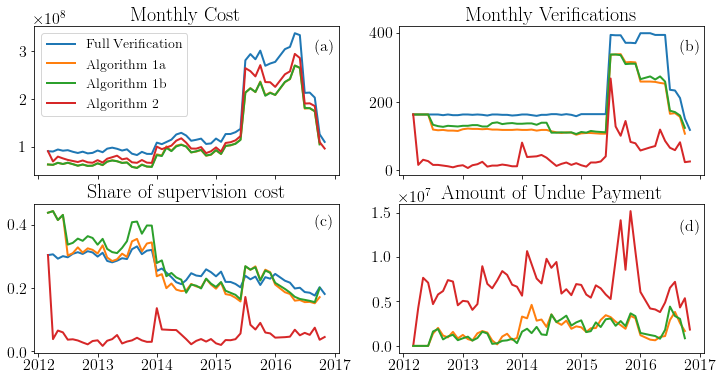

In [12]:
payments_sup = out_df.groupby(level = 1).validated_payment.sum()
verification_costs_sup = out_df.groupby(level = 1).sup_alarm.sum() * mean_supervision_cost
total_sup_cost = payments_sup + verification_costs_sup
perc_verification_sup = verification_costs_sup / total_sup_cost

N_verif_sup = out_df.groupby(level = 1).sup_alarm.sum()
N_verif_total = report_payment_data.groupby(level = 1).apply(len)

undue_payment = (out_df.validated_payment - report_payment_data.verified_payment)
undue_payment_plot = undue_payment.groupby(level= 1).sum()

f, axarr = plt.subplots(2,2, sharex=True)
axarr[0,0].plot(pd.to_datetime(total_cost[total_claimed_payments < 1e9].index) , total_cost[total_claimed_payments < 1e9].tolist() , label = 'Full Verification')
axarr[0,0].plot(aedes_data.loc['aedes_50'].index.get_level_values(0).to_timestamp() , aedes_data.loc['aedes_50' , 'total_payment'].tolist() , label = 'Algorithm 1a')
axarr[0,0].plot(aedes_data.loc['aedes_80'].index.get_level_values(0).to_timestamp() , aedes_data.loc['aedes_80' , 'total_payment'].tolist() , label = 'Algorithm 1b')
axarr[0,0].plot(pd.to_datetime(total_sup_cost[total_claimed_payments < 1e9].index) , total_sup_cost[total_claimed_payments < 1e9].tolist() , label = 'Algorithm 2')
axarr[0,0].set_title('Monthly Cost')
axarr[0,0].legend()
axarr[0,0].text(mdates.date2num(pd.to_datetime('2016-09-01')) , 3e8 , '(a)')


# N Verifications
axarr[0,1].plot(pd.to_datetime(N_verif_total[total_claimed_payments < 1e9].index) , N_verif_total[total_claimed_payments < 1e9].tolist())
axarr[0,1].plot(aedes_data.loc['aedes_50'].index.get_level_values(0).to_timestamp() , aedes_data.loc['aedes_50' , 'monthly_verifications'].tolist())
axarr[0,1].plot(aedes_data.loc['aedes_80'].index.get_level_values(0).to_timestamp() , aedes_data.loc['aedes_80' , 'monthly_verifications'].tolist())
axarr[0,1].plot(pd.to_datetime(N_verif_sup[total_claimed_payments < 1e9].index) , N_verif_sup[total_claimed_payments < 1e9].tolist())
axarr[0,1].set_title('Monthly Verifications')
axarr[0,1].text(mdates.date2num(pd.to_datetime('2016-09-01')) , 350 , '(b)')

axarr[1,0].plot(pd.to_datetime(perc_verification[total_claimed_payments < 1e9].index) , perc_verification[total_claimed_payments < 1e9].tolist())
axarr[1,0].plot(aedes_data.loc['aedes_50'].index.get_level_values(0).to_timestamp() , aedes_data.loc['aedes_50' , 'share_supervision_cost'].tolist())
axarr[1,0].plot(aedes_data.loc['aedes_80'].index.get_level_values(0).to_timestamp() , aedes_data.loc['aedes_80' , 'share_supervision_cost'].tolist())
axarr[1,0].plot(pd.to_datetime(perc_verification_sup[total_claimed_payments < 1e9].index) , perc_verification_sup[total_claimed_payments < 1e9].tolist())
axarr[1,0].set_title('Share of supervision cost')
axarr[1,0].text(mdates.date2num(pd.to_datetime('2016-09-01')) , 0.4 , '(c)')


# % overdeclaration spotted
axarr[1,1].plot(pd.to_datetime(undue_payment_plot[total_claimed_payments < 1e9].index) , undue_payment_plot[total_claimed_payments < 1e9].tolist() , color = 'C3')
axarr[1,1].plot(aedes_data.loc['aedes_50'].index.get_level_values(0).to_timestamp() , aedes_data.loc['aedes_50' , 'undue_payment_made'].tolist() , 'C1')
axarr[1,1].plot(aedes_data.loc['aedes_80'].index.get_level_values(0).to_timestamp() , aedes_data.loc['aedes_80' , 'undue_payment_made'].tolist() , 'C2')
axarr[1,1].set_title('Amount of Undue Payment')
axarr[1,1].text(mdates.date2num(pd.to_datetime('2016-09-01')) , 1.3e7 , '(d)')


### Trade-off

Finally, we want to offer a framework to choose between different algorithms. This choice should be according to two main trade-offs :
1. __the cost trade-off :__ As explicited earlier, displays the preferences of the program manager when it comes to pay for supervisions or for overpayments.
2. __the accuracy trade-off :__ As for any diagnostic tool, we have to make a choice between algorithms sensitivity and specificity. We express this trade-off as the trade-off between sensitivity (the probability an _ooc_ situation will be spotted) and the Positive Predictive Value of the algorithm (the probability that a triggered supervision is actually an _ooc_ situation).

We offer an interactive tool that allows program managers to define their zone of comfort in these two trade-offs, and thus to chose the algorithmic approach they prefer for their own program.

In [13]:
x_6 = [60000000 , 60000000 - max(undue_payment_plot)]
y_6 = [0 , max(undue_payment_plot)]

x_5 = [50000000 , 50000000 - max(undue_payment_plot)]
y_5 = [0 , max(undue_payment_plot)]

x_4  = [40000000 , 40000000 - max(undue_payment_plot)]
y_4  = [0 , max(undue_payment_plot)]

x_3  = [30000000 , 30000000 - max(undue_payment_plot)]
y_3  = [0 , max(undue_payment_plot)]

x_2  = [20000000 , 20000000 - max(undue_payment_plot)]
y_2  = [0 , max(undue_payment_plot)]

x_1  = [10000000 , 10000000 - max(undue_payment_plot)]
y_1  = [0 , max(undue_payment_plot)]

In [14]:
data_algo = pd.DataFrame({'supervision_costs':verification_costs_sup[total_claimed_payments < 1e9] , 
                          'undue_payment_made':undue_payment_plot[total_claimed_payments < 1e9].tolist() , 
                         'ppv':sup_ppv[total_claimed_payments < 1e9].tolist() , 
                         'sensitivity':sup_sens[total_claimed_payments < 1e9].tolist() , 'algorithm':'Algorithmic verification'})

In [15]:
data_plot = aedes_data.reset_index()
data_plot = data_plot[data_plot.algorithm != 'full_verification']
data_plot = data_plot[data_plot.npv > 0]
data_plot = data_plot.append(data_algo)

In [16]:
colormap = {'aedes_50': 'green', 'aedes_80': 'orange' , 'Algorithmic verification':'red'}

data_plot['color'] = data_plot['algorithm'].map(lambda x: colormap[x])


source = ColumnDataSource(
    data=dict(
        supervision_costs=data_plot['supervision_costs'],
        undue_payment_made=data_plot['undue_payment_made'],
        ppv=data_plot['ppv'],
        sensitivity=data_plot['sensitivity'],
        color=data_plot['color']
    )
)

output_notebook()

TOOLS = "box_zoom,wheel_zoom,pan,box_select,reset"

# create a new plot and add a renderer
left = figure(tools=TOOLS, width=500, height=500, title=None)
left.circle('supervision_costs', 'undue_payment_made', color = 'color' , source=source)
left.line(x_1 , y_1 ,  color = 'grey' , alpha = .7)
left.line(x_2 , y_2 ,  color = 'grey' , alpha = .7)
left.line(x_3 , y_3 ,  color = 'grey' , alpha = .7)
left.line(x_4 , y_4 ,  color = 'grey' , alpha = .7)
left.line(x_5 , y_5 ,  color = 'grey' , alpha = .7)
left.line(x_6 , y_6 ,  color = 'grey' , alpha = .7)
left.line(x_1 , y_1 ,  color = 'grey' , alpha = .7)
left.xgrid.grid_line_alpha = 0.5
left.ygrid.grid_line_dash = [6, 4]
left.yaxis.axis_label = 'Undue Payments Made'
left.xaxis.axis_label = 'Supervision Costs'
left.title = 'Program Costs tradeoff'

# create another new plot and add a renderer
right = figure(tools=TOOLS, width=500, height=500, title=None)
right.circle('sensitivity', 'ppv',  color = 'color' , source=source)
right.xgrid.grid_line_alpha = 0.5
right.ygrid.grid_line_dash = [6, 4]
right.yaxis.axis_label = 'Negative Predictive Value'
right.xaxis.axis_label = 'Sensitivity'
right.title = 'OOC monitoring'
p = gridplot([[left, right]])

show(p)

Loading BokehJS ...

In [17]:
if export_bokeh == True :
    script , div = components(p)
    print(div)
    print(script)